2025-08-04 20:16:03,894 - INFO - Market is open (regular or extended hours)
2025-08-04 20:16:03,895 - INFO - Processing AAPL...
2025-08-04 20:16:04,714 - INFO - AAPL RSI: nan
2025-08-04 20:16:04,715 - INFO - No buy signal for AAPL: RSI = nan
2025-08-04 20:16:04,716 - INFO - Processing MSFT...
2025-08-04 20:16:05,132 - INFO - MSFT RSI: nan
2025-08-04 20:16:05,132 - INFO - No buy signal for MSFT: RSI = nan
2025-08-04 20:16:05,133 - INFO - Processing META...
2025-08-04 20:16:05,536 - INFO - META RSI: nan
2025-08-04 20:16:05,536 - INFO - No buy signal for META: RSI = nan
2025-08-04 20:16:05,537 - INFO - 
Current Positions:
2025-08-04 20:16:05,745 - INFO - 6 share(s) of AAPL @ avg price 210.081667
2025-08-04 20:16:05,745 - INFO - 3 share(s) of META @ avg price 714.73
2025-08-04 20:16:05,746 - INFO - 3 share(s) of MSFT @ avg price 514.156667
2025-08-04 20:16:05,946 - INFO - 
Portfolio Summary:
Cash: 95052.82
Portfolio value: 100199.17


2025-08-05 00:43:32,129 - INFO - Processing AAPL...
2025-08-05 00:43:35,638 - ERROR - Error plotting candlestick for AAPL: 'Close'
2025-08-05 00:43:35,640 - INFO - AAPL RSI on 2025-04-28 00:00:00-04:00: nan
2025-08-05 00:43:35,641 - INFO - No trade signal for AAPL on 2025-04-28 00:00:00-04:00: RSI = nan
2025-08-05 00:43:35,641 - INFO - AAPL RSI on 2025-04-29 00:00:00-04:00: nan
2025-08-05 00:43:35,642 - INFO - No trade signal for AAPL on 2025-04-29 00:00:00-04:00: RSI = nan
2025-08-05 00:43:35,643 - INFO - AAPL RSI on 2025-04-30 00:00:00-04:00: nan
2025-08-05 00:43:35,643 - INFO - No trade signal for AAPL on 2025-04-30 00:00:00-04:00: RSI = nan
2025-08-05 00:43:35,644 - INFO - AAPL RSI on 2025-05-01 00:00:00-04:00: nan
2025-08-05 00:43:35,644 - INFO - No trade signal for AAPL on 2025-05-01 00:00:00-04:00: RSI = nan
2025-08-05 00:43:35,645 - INFO - AAPL RSI on 2025-05-02 00:00:00-04:00: nan
2025-08-05 00:43:35,645 - INFO - No trade signal for AAPL on 2025-05-02 00:00:00-04:00: RSI = nan

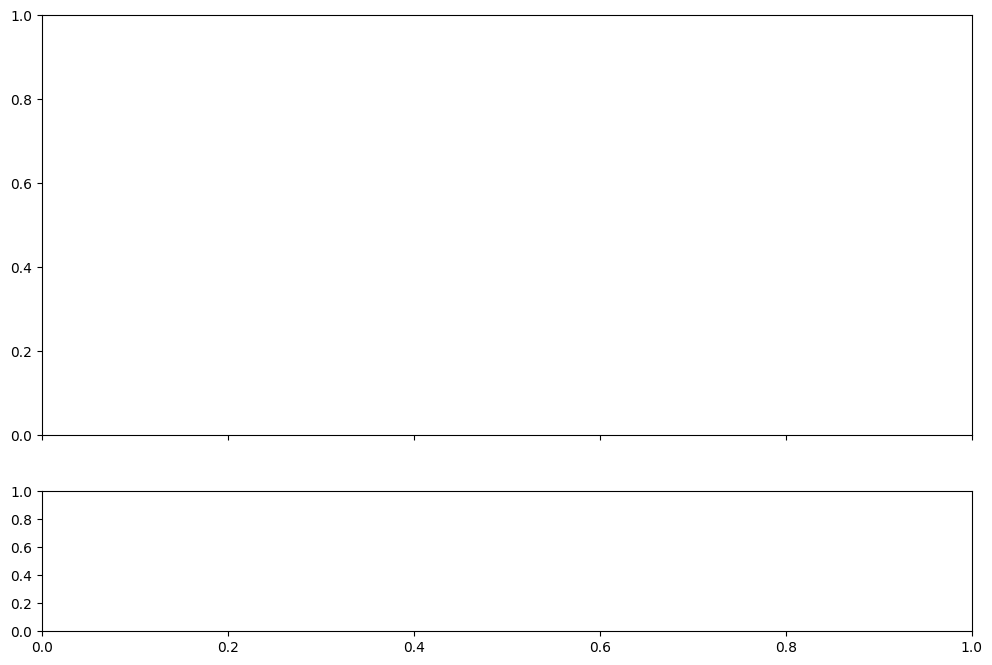

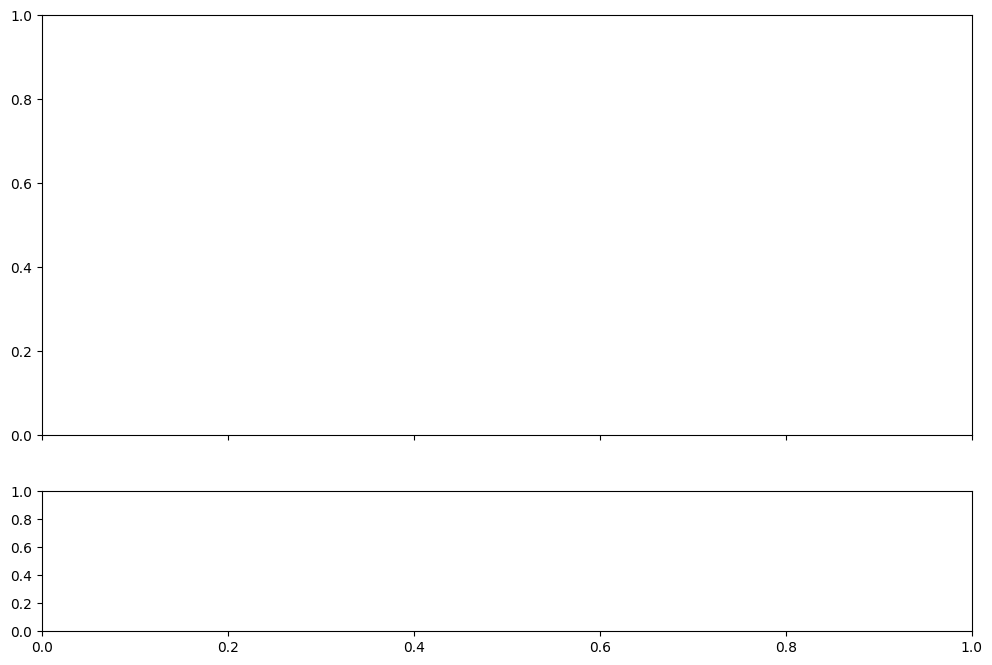

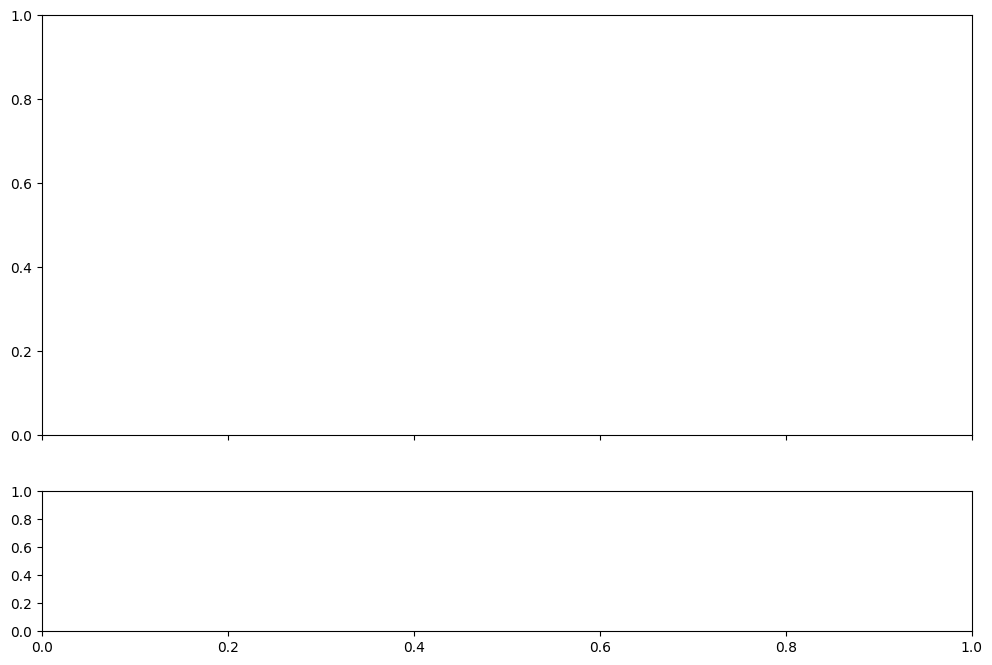

In [12]:
import pandas as pd
import time
import logging
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
from ta.momentum import RSIIndicator

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

SYMBOLS = ['AAPL', 'MSFT', 'META']
QTY_PER_STOCK = 10
MAX_POSITION_PER_STOCK = 0.1
INITIAL_CASH = 100000  
LOOKBACK_DAYS = 100  

portfolio = {
    'cash': INITIAL_CASH,
    'positions': {symbol: 0 for symbol in SYMBOLS},
    'equity': [],
    'dates': []
}

def plot_candlestick_rsi(symbol, data):
    """Plot candlestick chart with RSI and buy/sell signals."""
    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        up = data[data['Close'] >= data['Open']]
        down = data[data['Close'] < data['Open']]
        ax1.bar(up.index, up['High'] - up['Close'], 0.4, bottom=up['Close'], color='green')
        ax1.bar(up.index, up['Close'] - up['Open'], 0.2, bottom=up['Open'], color='green')
        ax1.bar(up.index, up['Open'] - up['Low'], 0.4, bottom=up['Low'], color='green')
        ax1.bar(down.index, down['High'] - down['Open'], 0.4, bottom=down['Open'], color='red')
        ax1.bar(down.index, down['Open'] - down['Close'], 0.2, bottom=down['Close'], color='red')
        ax1.bar(down.index, down['Close'] - down['Low'], 0.4, bottom=down['Low'], color='red')
        ax1.set_title(f"{symbol} Candlestick Chart")
        ax1.set_ylabel("Price")
        ax2.plot(data.index, data['rsi'], label='RSI', color='blue')
        ax2.axhline(70, color='red', linestyle='--', alpha=0.5)
        ax2.axhline(30, color='green', linestyle='--', alpha=0.5)
        buy_signals = data[data['rsi'] < 30]
        sell_signals = data[data['rsi'] > 70]
        ax2.scatter(buy_signals.index, buy_signals['rsi'], color='green', marker='^', label='Buy')
        ax2.scatter(sell_signals.index, sell_signals['rsi'], color='red', marker='v', label='Sell')
        ax2.set_title("RSI with Buy/Sell Signals")
        ax2.set_ylabel("RSI")
        ax2.legend()
        plt.tight_layout()
        plt.savefig(f"{symbol}_candlestick_rsi.png")
        plt.close()
        logging.info(f"Saved candlestick and RSI plot for {symbol}")
    except Exception as e:
        logging.error(f"Error plotting candlestick for {symbol}: {e}")

def plot_equity_curve(portfolio_values, dates):
    """Plot portfolio equity curve."""
    try:
        plt.figure(figsize=(10, 6))
        plt.plot(dates, portfolio_values, label='Portfolio Value', color='blue')
        plt.title("Portfolio Equity Curve")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value ($)")
        plt.legend()
        plt.grid(True)
        plt.savefig("portfolio_equity_curve.png")
        plt.close()
        logging.info("Saved portfolio equity curve")
    except Exception as e:
        logging.error(f"Error plotting equity curve: {e}")

def plot_drawdown(portfolio_values, dates):
    """Plot maximum drawdown."""
    try:
        running_max = np.maximum.accumulate(portfolio_values)
        drawdowns = (running_max - portfolio_values) / running_max * 100
        plt.figure(figsize=(10, 6))
        plt.plot(dates, drawdowns, label='Drawdown (%)', color='red')
        plt.title("Portfolio Drawdown")
        plt.xlabel("Date")
        plt.ylabel("Drawdown (%)")
        plt.legend()
        plt.grid(True)
        plt.savefig("portfolio_drawdown.png")
        plt.close()
        logging.info("Saved drawdown plot")
    except Exception as e:
        logging.error(f"Error plotting drawdown: {e}")

def plot_pairs_spread(symbol1, symbol2, data1, data2):
    """Plot price spread and z-score for pairs trading."""
    try:
        spread = data1['Close'] - data2['Close']
        spread_mean = spread.rolling(window=60).mean()
        spread_std = spread.rolling(window=60).std()
        zscore = (spread - spread_mean) / spread_std
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        ax1.plot(spread.index, spread, label='Spread', color='blue')
        ax1.plot(spread.index, spread_mean, label='Mean', color='black', linestyle='--')
        ax1.set_title(f"{symbol1}/{symbol2} Price Spread")
        ax1.set_ylabel("Spread ($)")
        ax1.legend()
        ax2.plot(spread.index, zscore, label='Z-Score', color='purple')
        ax2.axhline(2, color='red', linestyle='--', alpha=0.5)
        ax2.axhline(-2, color='red', linestyle='--', alpha=0.5)
        ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
        ax2.set_title("Z-Score for Pairs Trading")
        ax2.set_ylabel("Z-Score")
        ax2.legend()
        plt.tight_layout()
        plt.savefig(f"{symbol1}_{symbol2}_pairs_spread.png")
        plt.close()
        logging.info(f"Saved pairs spread plot for {symbol1}/{symbol2}")
    except Exception as e:
        logging.error(f"Error plotting pairs spread for {symbol1}/{symbol2}: {e}")

def plot_volume_volatility(symbol, data):
    """Plot trading volume and rolling volatility."""
    try:
        volatility = data['Close'].pct_change().rolling(window=20).std() * np.sqrt(252) * 100
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        ax1.bar(data.index, data['Volume'], label='Volume', color='gray')
        ax1.set_title(f"{symbol} Trading Volume")
        ax1.set_ylabel("Volume")
        ax1.legend()
        ax2.plot(data.index, volatility, label='Annualized Volatility (%)', color='orange')
        ax2.set_title(f"{symbol} Volatility")
        ax2.set_ylabel("Volatility (%)")
        ax2.legend()
        plt.tight_layout()
        plt.savefig(f"{symbol}_volume_volatility.png")
        plt.close()
        logging.info(f"Saved volume and volatility plot for {symbol}")
    except Exception as e:
        logging.error(f"Error plotting volume and volatility for {symbol}: {e}")

def fetch_market_data(symbol, timeframe='1d', limit=LOOKBACK_DAYS):
    """Fetch historical data using yfinance."""
    try:
        ticker = yf.Ticker(symbol)
        end_date = datetime.now()
        start_date = end_date - timedelta(days=limit)
        df = ticker.history(start=start_date, end=end_date, interval=timeframe)
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']].rename(columns=str.lower)
        return df
    except Exception as e:
        logging.error(f"Error fetching data for {symbol}: {e}")
        return None

def calculate_indicators(data):
    """Calculate RSI for the given data."""
    try:
        data['rsi'] = RSIIndicator(data['close'], window=14).rsi()
        return data
    except Exception as e:
        logging.error(f"Error calculating indicators: {e}")
        return None

def simulate_trade(symbol, qty, side, price, date):
    """Simulate a trade and update portfolio."""
    global portfolio
    try:
        cost = qty * price
        if side == 'buy' and portfolio['cash'] * MAX_POSITION_PER_STOCK >= cost:
            portfolio['positions'][symbol] += qty
            portfolio['cash'] -= cost
            logging.info(f"Simulated {side} order for {qty} shares of {symbol} at ${price:.2f}")
        elif side == 'sell' and portfolio['positions'][symbol] >= qty:
            portfolio['positions'][symbol] -= qty
            portfolio['cash'] += cost
            logging.info(f"Simulated {side} order for {qty} shares of {symbol} at ${price:.2f}")
        else:
            logging.warning(f"Insufficient funds or shares for {side} trade of {qty} shares of {symbol}")
        # Update portfolio equity
        equity = portfolio['cash'] + sum(portfolio['positions'][s] * price for s in SYMBOLS)
        portfolio['equity'].append(equity)
        portfolio['dates'].append(date)
    except Exception as e:
        logging.error(f"Simulated trade failed for {symbol}: {e}")

def check_existing_position(symbol):
    """Check simulated position for a symbol."""
    return portfolio['positions'][symbol]

if __name__ == "__main__":
    end_date = datetime.now()
    start_date = end_date - timedelta(days=LOOKBACK_DAYS)
    
    for symbol in SYMBOLS:
        logging.info(f"Processing {symbol}...")
        data = fetch_market_data(symbol)
        if data is not None:
            data = calculate_indicators(data)
            if data is not None and not data.empty:
                plot_candlestick_rsi(symbol, data)
                for date, row in data.iterrows():
                    current_qty = check_existing_position(symbol)
                    if current_qty >= QTY_PER_STOCK:
                        logging.info(f"Already holding {current_qty} shares of {symbol} on {date}. Skipping trade.")
                        portfolio['equity'].append(portfolio['cash'] + sum(portfolio['positions'][s] * data['close'].iloc[-1] for s in SYMBOLS))
                        portfolio['dates'].append(date)
                        continue
                    latest_rsi = row['rsi']
                    logging.info(f"{symbol} RSI on {date}: {latest_rsi:.2f}")
                    if latest_rsi < 30:  # Buy if oversold
                        simulate_trade(symbol, QTY_PER_STOCK, 'buy', row['close'], date)
                    elif latest_rsi > 70 and current_qty > 0:  # Sell if overbought
                        simulate_trade(symbol, min(current_qty, QTY_PER_STOCK), 'sell', row['close'], date)
                    else:
                        logging.info(f"No trade signal for {symbol} on {date}: RSI = {latest_rsi:.2f}")
                    portfolio['equity'].append(portfolio['cash'] + sum(portfolio['positions'][s] * row['close'] for s in SYMBOLS))
                    portfolio['dates'].append(date)
            else:
                logging.warning(f"No data or indicators for {symbol}")
        else:
            logging.warning(f"Skipping {symbol} due to data fetch error")
    
    # Plot portfolio graphs
    if portfolio['equity']:
        plot_equity_curve(portfolio['equity'], portfolio['dates'])
        plot_drawdown(portfolio['equity'], portfolio['dates'])
    
    # Plot pairs trading spread for AAPL/MSFT
    data1 = fetch_market_data('AAPL')
    data2 = fetch_market_data('MSFT')
    if data1 is not None and data2 is not None:
        plot_pairs_spread('AAPL', 'MSFT', data1, data2)
    
    # Plot volume and volatility for META
    data_meta = fetch_market_data('META')
    if data_meta is not None:
        plot_volume_volatility('META', data_meta)
    
    # Portfolio summary
    logging.info("\nCurrent Positions:")
    for symbol, qty in portfolio['positions'].items():
        if qty > 0:
            logging.info(f"{qty} share(s) of {symbol} @ avg price {data1['close'].iloc[-1] if symbol == 'AAPL' else data2['close'].iloc[-1] if symbol == 'MSFT' else data_meta['close'].iloc[-1]:.2f}")
    
    final_equity = portfolio['cash'] + sum(portfolio['positions'][s] * (fetch_market_data(s)['close'].iloc[-1] if fetch_market_data(s) is not None else 0) for s in SYMBOLS)
    logging.info(f"\nPortfolio Summary:\nCash: {portfolio['cash']:.2f}\nPortfolio value: {final_equity:.2f}")

In [13]:
import alpaca_trade_api as tradeapi
import time

api_key = 'PKMSXCZ5JFNRILSSDE7Z'
secret_key = '0xfaUPAQEifIEaSZbqOuUUEGlP4GJsa0GEAj5vHC'
base_url = 'https://paper-api.alpaca.markets'

api = tradeapi.REST(api_key, secret_key, base_url, api_version='v2')

clock = api.get_clock()
print(f"Market Open: {clock.is_open}")
print(f"Current Time (UTC): {clock.timestamp}")
print(f"Next Open: {clock.next_open} ")
print(f"Next Close: {clock.next_close}")


Market Open: False
Current Time (UTC): 2025-08-04 16:44:25.294592729-04:00
Next Open: 2025-08-05 09:30:00-04:00 
Next Close: 2025-08-05 16:00:00-04:00


In [11]:
pip install plotly

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB 1.9 MB/s eta 0:00:05
   - -------------------------------------- 0.4/9.6 MB 6.8 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/9.6 MB 8.1 MB/s eta 0:00:02
   ----- ---------------------------------- 1.3/9.6 MB 8.4 MB/s eta 0:00:01
   ------- -------------------------------- 1.9/9.6 MB 9.3 MB/s eta 0:00:01
   ---------- ----------------------------- 2.4/9.6 MB 9.6 MB/s eta 0:00:01
   ------------ --------------------------- 3.0/9.6 MB 9.6 MB/s eta 0:00:01
   -------------- ------------------------- 3.6/9.6 MB 10.3 MB/s eta 0:00:01
   ---------------- ----------------------- 4.1/9.6 MB 10.4 MB/s eta 0:00:01
   ------------------- -------------------- 4.6/9.6 MB 10.6 MB/s eta 0:00:01
   --------------------- ------------------ 5.2/9.6 MB 10.4 MB/s eta 0:00:01
   ----------------------- ---------------- 5.8/9.6 MB 10.8 MB/s eta 0:00:01
   -----------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import alpaca_trade_api as tradeapi
from ta.momentum import RSIIndicator
import pandas as pd
import time
import logging
import pytz
from tenacity import retry, stop_after_attempt, wait_exponential
from datetime import datetime

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

api_key = 'PKMSXCZ5JFNRILSSDE7Z'
secret_key = '0xfaUPAQEifIEaSZbqOuUUEGlP4GJsa0GEAj5vHC'
base_url = 'https://paper-api.alpaca.markets'
api = tradeapi.REST(api_key, secret_key, base_url, api_version='v2')
SYMBOLS = ['AAPL', 'MSFT', 'META']
QTY_PER_STOCK = 10
MAX_POSITION_PER_STOCK = 0.1
DUBAI_TZ = pytz.timezone("Asia/Dubai")

market_status_cache = {"timestamp": None, "is_open": None, "next_open": None}

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
def check_market_open():
    """Check if the market is open, with caching and local time conversion."""
    global market_status_cache
    current_time = datetime.now(pytz.UTC)

    if market_status_cache["timestamp"] and (current_time - market_status_cache["timestamp"]).total_seconds() < 300:
        logging.info("Using cached market status")
        if not market_status_cache["is_open"]:
            next_open_dubai = market_status_cache["next_open"].astimezone(DUBAI_TZ)
            logging.info(f"Market is closed. Next open at {next_open_dubai.strftime('%Y-%m-%d %H:%M:%S %Z')}")
        return market_status_cache["is_open"]

    try:
        clock = api.get_clock()
        logging.debug(f"clock.is_open type: {type(clock.is_open)}, value: {clock.is_open}")
        market_status_cache = {
            "timestamp": current_time,
            "is_open": clock.is_open,
            "next_open": clock.next_open
        }

        if clock.is_open:
            logging.info("Market is open (regular or extended hours)")
            return True
        else:
            next_open_dubai = clock.next_open.astimezone(DUBAI_TZ)
            time_until_open = (clock.next_open - current_time).total_seconds() / 3600.0
            logging.info(f"Market is closed. Next open at {next_open_dubai.strftime('%Y-%m-%d %H:%M:%S %Z')} "
                         f"({time_until_open:.2f} hours from now)")
            return False
    except tradeapi.rest.APIError as e:
        logging.error(f"Alpaca API error: {e}")
        return False
    except Exception as e:
        logging.error(f"Unexpected error checking market status: {e}")
        return False

def fetch_market_data(symbol, timeframe='1D', limit=100):
    try:
        bars = api.get_bars(symbol, timeframe, limit=limit).df
        return bars
    except Exception as e:
        logging.error(f"Error fetching data for {symbol}: {e}")
        return None

def calculate_indicators(data):
    try:
        data['rsi'] = RSIIndicator(data['close'], window=14).rsi()
        return data
    except Exception as e:
        logging.error(f"Error calculating indicators: {e}")
        return None

def place_order(symbol, qty, side, max_position=0.1):
    try:
        account = api.get_account()
        cash = float(account.cash)
        latest_price = api.get_latest_trade(symbol).price
        if cash * max_position < qty * latest_price:
            logging.warning(f"Insufficient funds for {side} trade of {qty} shares of {symbol}")
            return None
        order = api.submit_order(symbol=symbol, qty=qty, side=side, type='market', time_in_force='gtc')
        logging.info(f"Placed {side} order for {qty} shares of {symbol} at ${latest_price:.2f}")
        return order
    except Exception as e:
        logging.error(f"Order failed for {symbol}: {e}")
        return None

def check_existing_position(symbol):
    try:
        position = api.get_position(symbol)
        return int(position.qty)
    except Exception:
        return 0

if __name__ == "__main__":
    if check_market_open():
        for symbol in SYMBOLS:
            logging.info(f"Processing {symbol}...")
            current_qty = check_existing_position(symbol)
            if current_qty >= QTY_PER_STOCK:
                logging.info(f"Already holding {current_qty} shares of {symbol}. Skipping trade.")
                continue
            
            data = fetch_market_data(symbol)
            if data is not None:
                data = calculate_indicators(data)
                if data is not None and not data.empty:
                    latest_rsi = data['rsi'].iloc[-1]
                    logging.info(f"{symbol} RSI: {latest_rsi:.2f}")
                    if latest_rsi < 30:  # Buy if oversold
                        order = place_order(symbol, QTY_PER_STOCK, 'buy', MAX_POSITION_PER_STOCK)
                        if order:
                            time.sleep(1)  # Avoid API rate limits
                    else:
                        logging.info(f"No buy signal for {symbol}: RSI = {latest_rsi:.2f}")
                else:
                    logging.warning(f"No data or indicators for {symbol}")
            else:
                logging.warning(f"Skipping {symbol} due to data fetch error")
    else:
        logging.info("No trading: Market is closed")

    logging.info("\nCurrent Positions:")
    positions = api.list_positions()
    for pos in positions:
        logging.info(f"{pos.qty} share(s) of {pos.symbol} @ avg price {pos.avg_entry_price}")

    account = api.get_account()
    logging.info(f"\nPortfolio Summary:\nCash: {account.cash}\nPortfolio value: {account.portfolio_value}")
